# Task #3: find the Spectrum!

What is a spectrum? A spectrum is the description of the light emitted by a source and it consists of a list of wavelengths and for each of them a value proportional to the flux intensity. So it is usually represented by a graph where the x-coordinate is the wavelength and the y-coordinate is the flux.

Why do we want to extract a spectrum? Well, that's the goal of Spectroscopy: to study the light from a source decomposing it in all its wavelenghts.

How? First, it is necessary to identify the position of the source along the cross-dispersion direction, i.e. along the slit (never forget the general design of the instrumentation used). Second, for each wavelength (for now it is just a pixel in the dispersion direction), the pixels along the cross-dispersion direction must be summed. The sum extends to a number of pixels around the position of the source that define the aperture a.k.a. extraction window.

In [11]:
# Importing all needed packages
# Standard packages for data visualization and modeling
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
%matplotlib notebook

# Packages for reading astronomical data stored in fits files and accessing file paths
from astropy.io import fits  # to read fits files with python
import glob  # to find pathnames

# Packages for importing ad-hoc modules 
import importlib
import sys
#importlib.reload(sys.modules['data_reduction']) # uncomment when you edit the module data_reduction.py
from data_reduction import *

# Other
import datetime
import timeit
from regions import RectanglePixelRegion
import os

For start, let's save into a list the paths of all the fits files that have been bias-subtracted and flat-normalized in our data directory and let's display them below.

In [12]:
# Directory of the data 
path2data = '/home/masi1109/Documents/PhD/ObsII/not2mattia'
# List of filenames that have been bias-subtracted and flat-corrected
fnames = glob.glob(path2data+'/*_b_f.fits*', recursive=True)   
fnames

['/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130146_b_f.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130144_b_f.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130155_b_f.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130145_b_f.fits',
 '/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130132_b_f.fits']

# Choose a Science Object and check it

In the cell below we access one science object frame and check that it has been calibrated in the previous two workbooks.

We print below:

-> the name of the file of the science frame

-> the image type and the observation mode

-> the information on the history of the file: has it been bias-subtracted and flat-normalized?

We also plot the complete science frame.

/home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130145_b_f.fits 
Image type: OBJECT Obs. Mode: SPECTROSCOPY
HISTORY: Master Bias subtracted on 2021-02-19 17:32:48 using master bias file /ho
me/masi1109/Documents/PhD/ObsII/not2mattia/master_bias_mean.fits
Master flat divided on: 2021-02-19 17:33:45 using master flat file /home
/masi1109/Documents/PhD/ObsII/not2mattia/master_flat_mean.fits


<IPython.core.display.Javascript object>


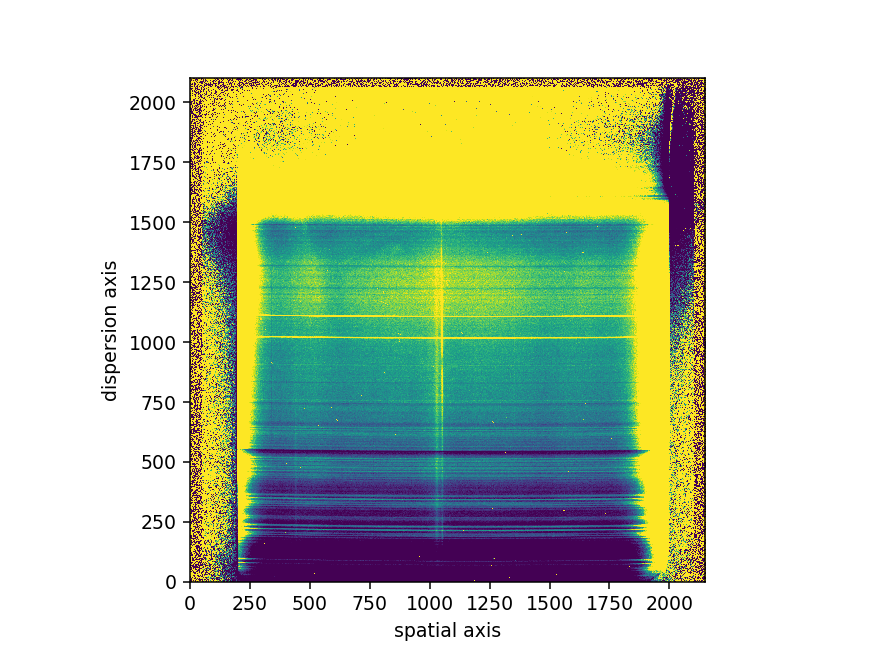

In [13]:
# Let's extract the spectrum of each source corresponding to the file ALAe130146_b_f.fits
# We want to make sure that the file is a calibrated (bias-subtracted, flat-normalized) spectroscopy frame

file = path2data + "/ALAe130145_b_f.fits"

hdul = fits.open(file)  # reading the fits file (headers and pixel values)
    
# Region of interest for data calibration
xmin, xmax, ymin, ymax = 300, 1800, 200, 1500 
    
if hdul[0].header['IMAGETYP'] == 'OBJECT' and hdul[0].header['OBS_MODE'] == 'SPECTROSCOPY':
    print(file, "\nImage type: OBJECT", "Obs. Mode: SPECTROSCOPY")
        
    # checking bias subtraction and flat normalization
    flat_check = hdul[0].header['HISTORY']
    print("HISTORY:", flat_check)
        
    frame = hdul[1].data
    f = frame[ymin:ymax, xmin:xmax]
    plt.figure()
    plt.imshow(frame, origin='lower', vmin=np.median(f)-2*np.std(f), 
                vmax=np.median(f)+2*np.std(f)) # use data of interest f to set the color scale
    plt.xlabel("spatial axis")
    plt.ylabel("dispersion axis")

else:
    print("The image type of this frame is:", hdul[0].header['IMAGETYP'])
    print("The observation mode of this frame is:", hdul[0].header['OBS_MODE'])
    
hdul.close()

# Find the source along the spatial axis x

In this cell we identify the position of the source along the spatial (cross-dispersion) axis by summing the pixels along the dispersion axis (y) over a stripe of 20 pixels (between 200 and 220).

NB Our science object is a SN (narrow peak) inside a galaxy (extended peak). Let's say we want to extract the spectrum of the SN only...

<IPython.core.display.Javascript object>


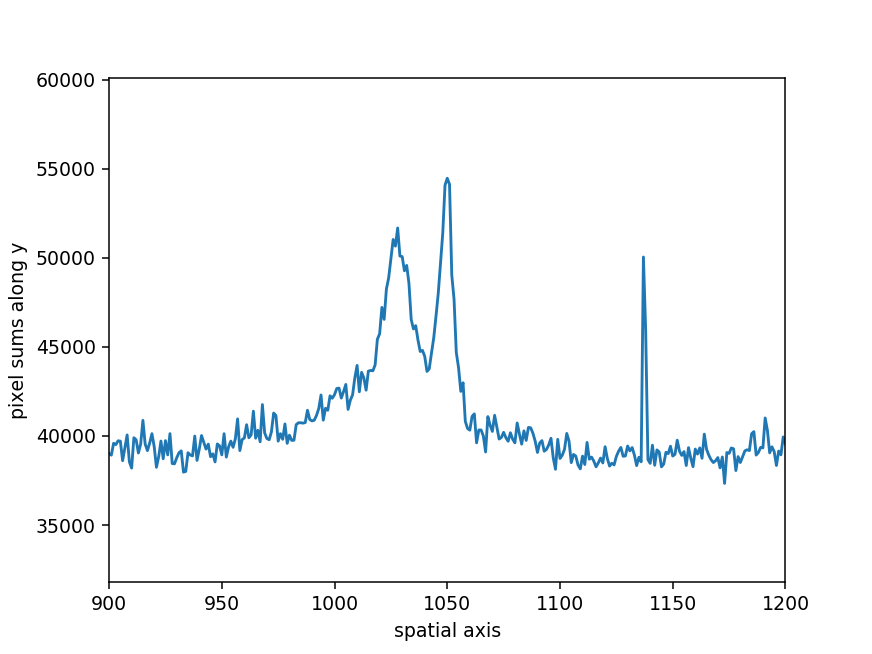

Text(0, 0.5, 'pixel sums along y')

In [14]:
# Specify the y-coordinate range (dispersion axis) of interest for computing the flux profile
# choose a narrow (10-20px) stripe at low coordinates, after the sky lines (dark horizontal lines)
yrange_min = 200
yrange_max = 220
        
# Plotting the flux profile along the spatial axis (x)
x_px = np.arange(xmin, xmax)
ysums = frame[yrange_min:yrange_max,:].sum(axis=0)
plt.figure()
plt.plot(x_px, ysums[xmin:xmax], label="flux profile")
plt.xlim(900,1200)
plt.xlabel("spatial axis")
plt.ylabel("pixel sums along y")

# Define the aperture as a function of the dispersion coordinate y

The extraction window is defined by a range of pixels in the spatial axis (x) that is determined by the position of the source. This one, however, is not exactly constant at all y-coordinates. Therefore in the cell below we do the so-called continuum-tracing, i.e. we define an aperture for the spectrum-extraction for each stripe of 10px along the dispersion axis (y).

In order to define the aperture, for each stripe we fit a gaussian to the flux profile (as the one plotted above) and take an interval on the x-axis defined by central_coordinate +- 2*standard_deviaiton.

We pint below the list of the said apertures and show one of them in a plot.

Standard Deviation of the Gaussian searched in the range:  1.2739827004320283 6.369913502160141 pix

y-coordinate (lower boundary)   amplitude   central coordinate   standard deviation
200 6383.736461084652 1049.296988348808 3.4655776336177837
210 6968.218367764329 1049.266341859885 4.216410842573916
220 7735.282346286258 1049.8671439710472 6.369913502160141
230 6209.081894363464 1049.4278051032384 2.729165251173941
240 7493.146798533285 1049.4703559297932 4.449023798362447
250 7401.309827650933 1049.3584123208043 5.435957506338989
260 6815.552000821657 1049.463766363796 5.050473826834016
270 5882.357150858844 1049.1673472271743 4.05581405498581
280 5157.921373272035 1049.3989846255809 6.156330551065841
290 5022.133433866047 1048.8926477118619 6.369913502160141
300 4830.713909741271 1049.1787834640907 6.369913502160141
310 4893.841770909873 1048.6805512158671 6.369913502160141
320 4069.1317055628706 1049.14603719853 6.369913502160141
330 3496.9023228367514 1048.25230908657 6.3699135021

<IPython.core.display.Javascript object>


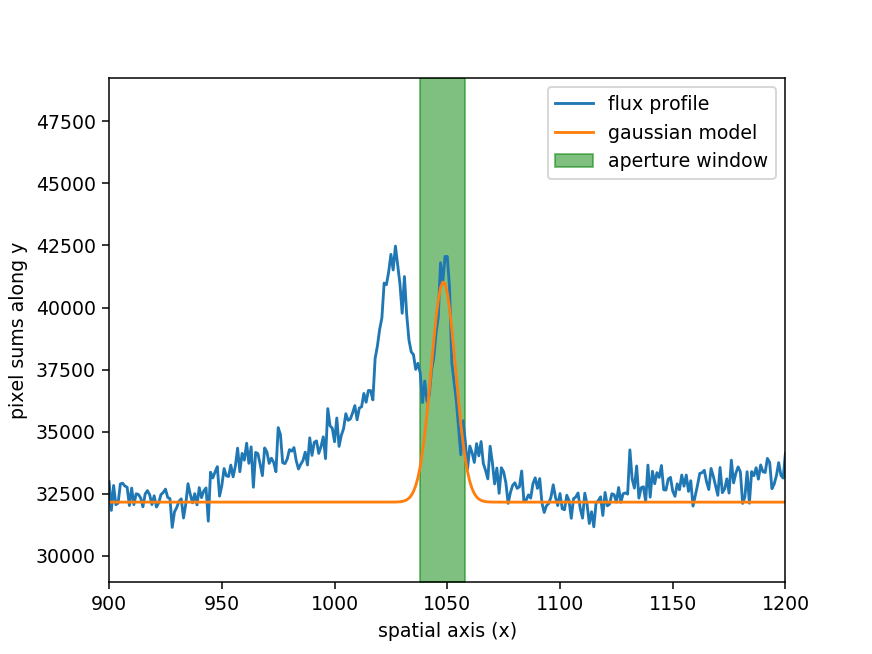

930 12581.512704262219 1048.341397308415 4.248312688985145
940 17782.110824252322 1048.4312180003128 3.8474583129526336
950 20455.29016310029 1048.458303654383 3.3097806919086765
960 19444.96153131145 1048.3790012569582 3.6546010206876542
970 19521.745350016885 1048.3635312613883 3.5967003558048893
980 20711.69315187979 1048.2423638134173 3.707026229050524
990 20797.20185917574 1048.301982253994 3.771045251507711
1000 19169.062236556 1048.1763436232611 3.8516504605647985
1010 19292.602103245237 1048.3014689475376 4.358699264345066
1020 18001.253665298544 1048.1666689675185 3.2829200601280037
1030 20132.03459633928 1048.1024645001319 3.770264339811778
1040 21470.74988204359 1048.0383701950998 3.5003197675271136
1050 20476.632995946922 1047.933038783524 3.7223892056608077
1060 19939.275946541304 1047.907514956126 3.7872146233295068
1070 20491.277694985878 1047.9754714706562 3.878319134782258
1080 19523.125104276965 1047.8971247255315 3.6996620055720926
1090 17935.623857049304 1047.808942

In [15]:
# What aperture parameters do you want, approximately? Please specify based on the SN flux profile above!
amp = 4.1e6  # amplitude of the peak
x_cen = 1049  # central x coordinate
sigma = 3  # standard deviation

# Please write here these other important properties of the observations (check on the logs!)
seeing = 0.6  # seeing FWHM (in arcsec) 
pix_scale = 0.2  # pixel scale (in arcsec/pc) / Matthew told me so (but check on the header...) 

min_sigma = seeing / pix_scale / (2*np.sqrt(2*np.log(2)))  # profile width can't be smaller than this
max_sigma = 5*min_sigma
print("Standard Deviation of the Gaussian searched in the range: ", min_sigma, max_sigma, "pix\n")

# In order to define the extraction aperture, we fit the flux profile with a gaussian
# that will be used to extract the spectrum as a weight when summing pixels along x axis

# Since the position (x) of the source can vary as a function of the dispersion coordinate (y)
# the fit is done for several horizontal stripes of width dy=20 pixels

dy = 10 #  stripes of 10px width
ys = []
xs_min = []
xs_max = []
amps = []
means = []
stddevs = []

print("y-coordinate (lower boundary)   amplitude   central coordinate   standard deviation")

for yrange_min in np.arange(200, 1200, dy): 
    
    # Flux profile - Data
    yrange_max = yrange_min + dy
    ysums = frame[yrange_min:yrange_max,:].sum(axis=0) 
    
    # Gaussian Model
    g_init = models.Gaussian1D(amplitude=amp, mean=x_cen, stddev=sigma,   
                           bounds={"mean" : [1040,1060], "stddev" : [min_sigma,max_sigma]})
    fit_g = fitting.LevMarLSQFitter()
        
    # I want to fit only the right side of the SN profile caus the left is contaminated by the galaxy
    xfit_min = int(x_cen - max_sigma)
    xfit_max = xmax
    xfit = np.arange(xfit_min, xfit_max)
    const = np.median(ysums[700:900])  # constant signal (gaussian is on top of that)
    g = fit_g(g_init, xfit, ysums[xfit_min:xfit_max]-const)
    
    # Save window properties in arrays
    ys.append((yrange_min+yrange_max)/2)
    xs_min.append(int(g.mean - 2*g.stddev))
    xs_max.append(int(g.mean + 2*g.stddev))
    amps.append(g.amplitude[0]) #  these model attributes are of the form Parameter('amplitude', value=15937)
    means.append(g.mean[0]) #  [0] gives the value only
    stddevs.append(g.stddev[0]) #  which is all we need
    
    # Reset the initial guesses as best fit values of this stripe
    amp = g.amplitude
    x_cen = g.mean
    sigma = g.stddev
    
    # Uncomment if you wan to check the best-fit gaussian parameters of each stripe
    print (yrange_min, amps[-1], means[-1], stddevs[-1] )
    
    # Plot the fit of stripe at y of your choice
    if yrange_min == 920:
        plt.figure()
        plt.xlabel("spatial axis (x)")
        plt.ylabel("pixel sums along y")
        plt.plot(x_px, ysums[xmin:xmax], label="flux profile")
        plt.plot(x_px, g(x_px)+const, label="gaussian model")
        xrange = (x_px > xs_min[-1]) & (x_px < xs_max[-1])
        plt.fill_between(x_px, 0.9*const, 1.2*(const+g.amplitude), xrange==1, alpha=0.5, color='green', 
                     label="aperture window")
        plt.ylim(0.9*const, 1.2*(const+g.amplitude))
        plt.legend()
        plt.xlim(900, 1200)


# Interpolate window's properties and extract the spectrum

We now save the properties of the aperture defined above into both a variable and a file that may be used later in the data reduction.

For each stripe in the dispersion coordinate y we plot the properties defining the fitted gaussian and therefore the aperture: amplitude, central coordinate, standard deviation. If you look at these functions (gaussian parameters as a function of y) you might notice that there is some noise that we want to filter out (e.g. around pixel 950 there is a big dip in the amplitude due to the Telluric atmospheric absoprtion). 

In order to filter out this noise, we fit a polynomial (orange lines in the plots below) and interpolate its value at each y-coordinate. These fits, interpolation and plots are implemented in data_reduciton.py and called with the function "extract_spectrum".

Plotted below is also the extracted spectrum obtained by summing the pixels along the spatial axis (x) weighted with the fitted gaussian for each spectral pixel (y-coorindate). The spectral pixels in this last plot are reversed so that the pixel number increases as the wavelength increase, which will be relevant in the next workbook where we will do the wavelength calibration!

<IPython.core.display.Javascript object>


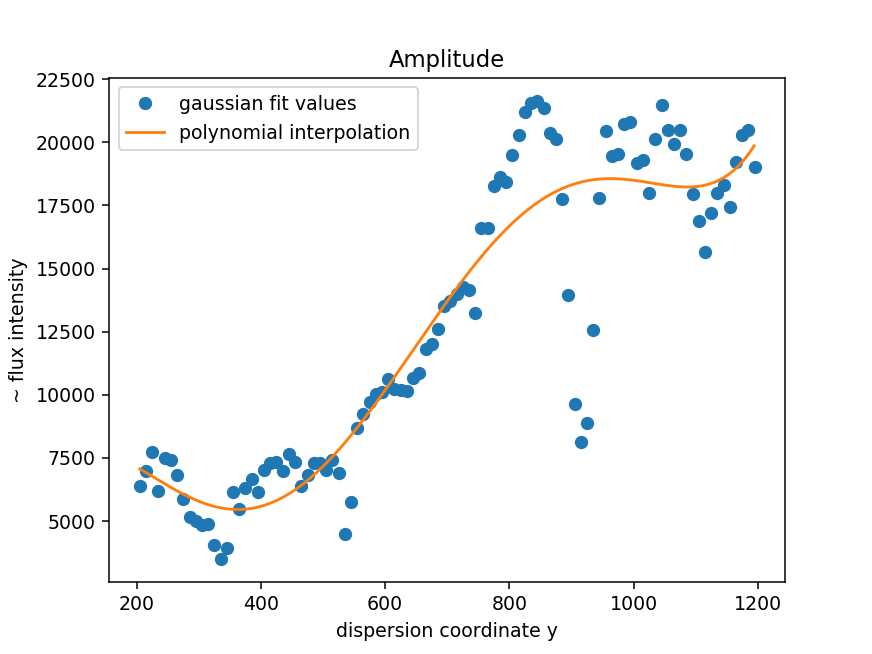

<IPython.core.display.Javascript object>


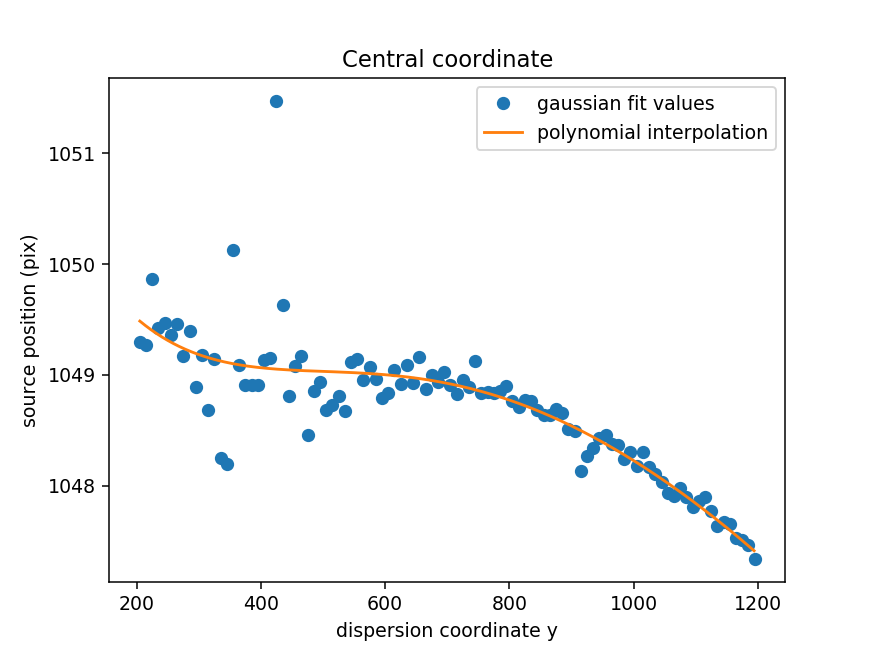

<IPython.core.display.Javascript object>


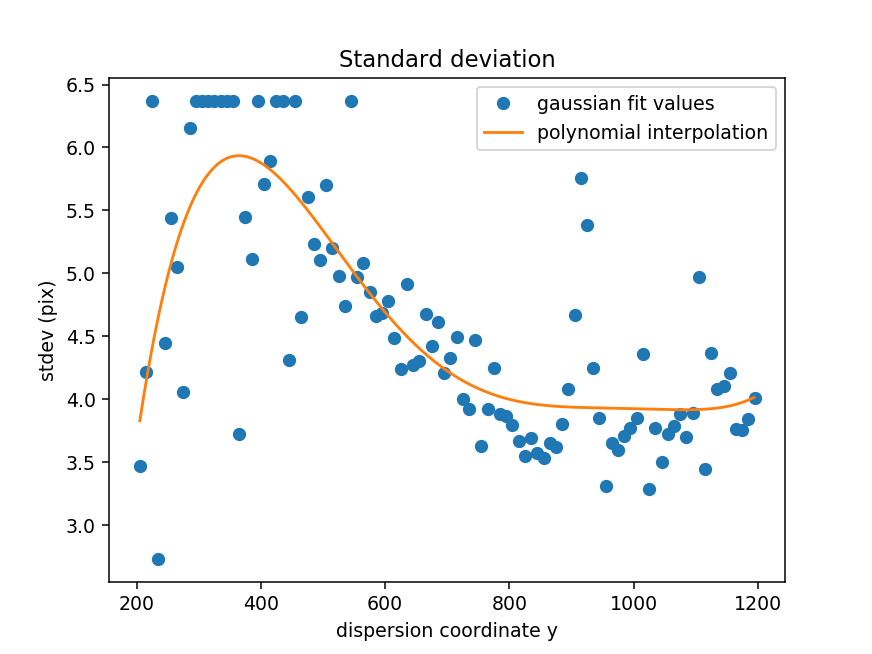

<IPython.core.display.Javascript object>


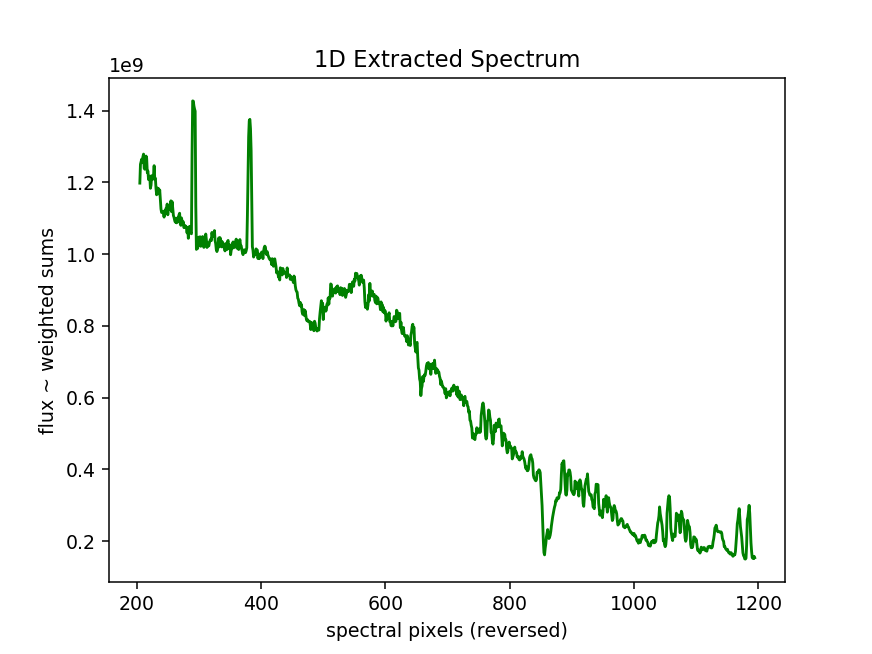

In [16]:
# Define the aperture window with the properties derived above
# the class used is defined in data_reduction.py
window = ExtractionWindow(xs_min, xs_max, ys, amps, means, stddevs)  

# Save the window with its properties into a pickle file
import pickle
pickle.dump(window, open(path2data+"/ALAe130145_window.p", "wb"))

# Use the window defined above to extract the spectrum
# For each spectral pixel (y-coordinate) the flux is proportional to the sum 
# of the pixels along the spatial axis (x) weighted with the fitted gaussian

# Computing the spectrum using a function defined in data_reduction.py
# The function interpolates the gaussian parameters fitted above and plot them as a function of y
spec_px, flux = extract_spectrum(frame, window)
    
# Plotting the spectrum
plt.figure()
plt.title("1D Extracted Spectrum")
plt.plot(spec_px, flux, c='green')
plt.xlabel("spectral pixels (reversed)")
plt.ylabel("flux ~ weighted sums")
plt.savefig("figs/SN_spectrum_uncalibrated.pdf")

# Saving the spectrum in a text file
file_out = open(path2data+"/ALAe130145_1dSpectrum.txt", "w")
file_out.write("# 1d spectrum optimally extracted from frame ALAe130145_b_f.fits\n")
file_out.write("# Column 1: pixel    Column 2: flux\n")

for i in range(len(spec_px)):
    s = '{:d}    {:.4f}\n'.format(spec_px[i], flux[i])
    file_out.write(s)
    
file_out.close()

# Alternative: extract spectrum from a fixed window

Gaussian-weighted spectral extraction is not necessarily the best way to proceed. We might want to use a fixed range of spatial pixels independent on the spectral coordinate and no weighting, for example if we want to extract the spectrum from a given position in a galaxy.

This task is easier. We just need to specify range on the spatial axis (x) and sum the pixel values within that range for each spectral coordinates to obtain the fluxes of the spectrum.

Below we do this for extracting a spectrum from the central part of the galaxy and plot the result.

<IPython.core.display.Javascript object>


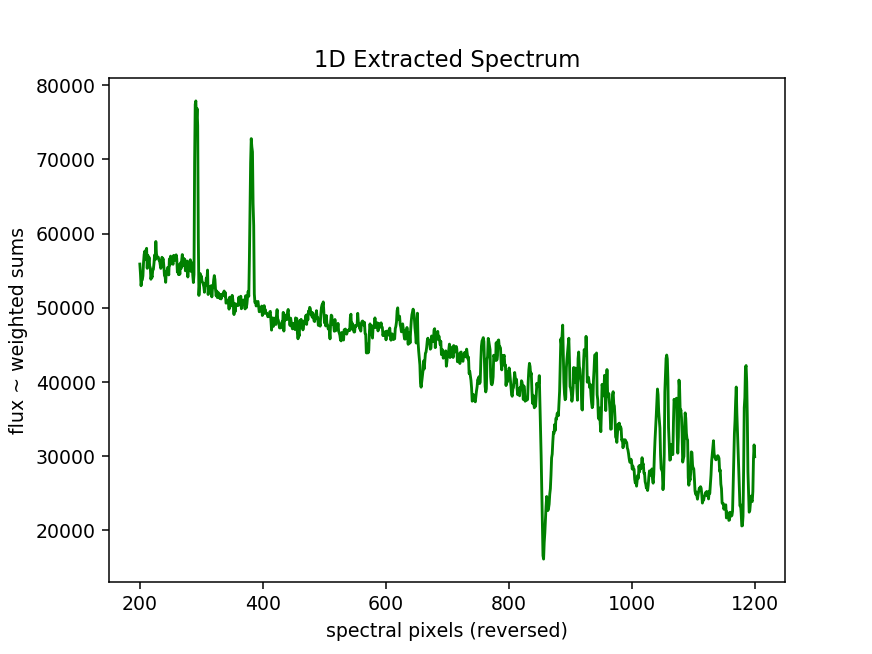

In [17]:
# Define the aperture window with the minimum and maximum value of the spatial coordinate
win_xmin, win_xmax = 1022, 1034  # this windows captures the central part of the galaxy

# Use the window defined above to extract the spectrum
# For each spectral pixel (y-coordinate) the flux is proportional to the sum 
# of the pixels along the spatial axis (x) 

spec_px = np.arange(200, 1200)
flux = frame[200:1200,win_xmin:win_xmax].sum(axis=1)
# Spectral pixels axis is reversed, so I flip the flux array so that pixel values grow as wavelength grows
flux = np.flip(flux)

# Plotting the spectrum
plt.figure()
plt.title("1D Extracted Spectrum")
plt.plot(spec_px, flux, c='green')
plt.xlabel("spectral pixels (reversed)")
plt.ylabel("flux ~ weighted sums")
plt.savefig("figs/galaxy_centre_spectrum_uncalibrated.pdf")

# Saving the spectrum in a text file
file_out = open(path2data+"/ALAe130145_1dSpectrum_galaxy_centre.txt", "w")
file_out.write("# 1d spectrum optimally extracted from frame ALAe130145_b_f.fits (galaxy centre)\n")
file_out.write("# Column 1: pixel    Column 2: flux\n")

for i in range(len(spec_px)):
    s = '{:d}    {:.4f}\n'.format(spec_px[i], flux[i])
    file_out.write(s)
    
file_out.close()

# Repeat for the other Science Objects...